# Neural Network

    In this network, we act as before, except that we add a inhibitory neuron to the output layer. According to the diagrams, it can be seen that one of the neurons spikes less or only one of the two neurons spikes, which varies according to the parameters and weights of the three external neurons.
    we change these parameters in these diagrams: A ± ( w ) , τ ,Synaptic-weights

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

In [2]:
def neural_network(I_init, gl, Cm, num1,num2,num3, A_neg= -1.5, A_plus= 2, tau_t= 0.005):
    ######### Constants
    U_rest      =   -0.065                  # restint membrane potential [U]
    U_reset     =   -0.065
    thresh  =   -0.050                      # spiking threshold [U]
    tau =  Cm/gl
    A_plus = A_plus                         #amplitude parameter A ± ( w ) ,we consider this constant!
    A_neg = A_neg
    tau_t = tau_t                           #tau for stdp rule
  

    ######### Setup
    # TIME
    T       =   0.200                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    tp =[[4,15,4,7,7,10000,10000,10000,10000,10000],[10000,10000,10000,10000,10000,5,10,5,2,2]]
    
    
    # VOLTAGE
    U_inp       =   np.zeros((10,len(time)))   # array for saving Voltage history - input layer
    U_inp[:,0]  =   U_rest                     # set initial to resting potential 
    U_out       =   np.zeros((3,len(time)),dtype = np.float64)#outer layer
    U_out[:,0]  =   U_rest
    
    # CURRENT
    I_init = I_initial(I_init=I_init, time=time)
    I = np.zeros((10,len(time)))
    I_out       =   np.zeros((3,len(time)))
    

    ######### Measurements
    spikes = [[0] for i in range(10)]         #save the time of neuron's spike - input layer neurons 
    spikes_out = [[0],[0],[0]]                #output layer neurons - spike time
    
    delta_W = [[],[],[]]                      #save the changing of synapse weight [∆ w]
    delta_T = [[],[],[]]                      #save the |∆ t | = | t-post − t-pre | 
    
    W = np.zeros((10,3))
    W[:,0] = abs(np.random.normal(3,1,size=(10)))/num1  #set weights for the connection
    W[:,1] = abs(np.random.normal(3,1,size=(10)))/num2
    W[:,2] = abs(np.random.normal(3,1,size=(10)))/num3
    cnt = 0
    
    ######### Simulation
    for i in range(1,len(time)):
        
            
        #cnt = abs(cnt - 1*bool(i% 550 == 0)) 
        if(i%550==0): cnt = randint(0,550)%2
        for j in range(10):
            
            if(i% 550 == 0):  U_inp[j][i-1] = U_rest
            #compute current
            I[j][i]= I[j][i] + (I_init[i]+bool(i%tp[cnt][j] == 0)*0.0027)*bool(tp[cnt][j] != 10000)
            # use " tau.(du/dt) = -(U(t) -U_rest) + R.I(t))" to get this equation
            U_inp[j][i] = (((U_rest - U_inp[j][i-1]) + I[j][i]/gl)*dt)/tau + U_inp[j][i-1]
            
            
            # in case we exceed threshold               
            if U_inp[j][i] > thresh :
                
                U_inp[j][i-1] = 0.04         # set the last step to spike value
                U_inp[j][i] = U_reset        # current step is resting membrane potential
            
                spikes[j].append(time[i])    # count spike
                
                for l in range(3):
                    time_diff = spikes[j][-1]-spikes_out[l][-1]
                    if(len(spikes_out[l]) != 1 and time_diff>0 and time_diff<time[550]):
                        #use "∆ w − = A − ( w ) · exp(−|∆ t |/τ − ) at t-pre " to get this equation
                        delta_T[l].append((spikes_out[l][-1] - spikes[j][-1]))
                        delta_W[l].append((A_neg*math.exp(-1*abs(delta_T[l][-1])/tau_t)))
                        if(W[j,l] > abs(delta_W[l][-1])): W[j,l] += delta_W[l][-1]
                    
                if(i< 9996):
                    add_amount = I_values(j,i,I_init,time,spikes,W)
                    I_out[1:3,i+1:i+2] = I_out[1:3,i+1:i+2] + add_amount[1:3,:]
                    I_out[0,i:i+1] = I_out[0,i:i+1] + add_amount[0,:]
                
        #output layer neurons        
        for l in range(3):
            U_out[l,i] = (((U_rest - U_out[l,i-1]) + I_out[l,i]/gl)*dt)/tau + U_out[l,i-1]
            if U_out[l][i] > thresh:
                U_out[l][i-1] = 0.04      # set the last step to spike value
                U_out[l][i] = U_reset     # current step is resting membrane potential 
                spikes_out[l].append(time[i])
                if l==1 :
                    minus_amount = I_values(l,i-1,I_init,time,spikes_out,W)
                    I_out[1:3,i:i+2] = I_out[1:3,i:i+2] - minus_amount[1:3,:]
                for j in range(10):
                    if(time[i] - spikes[j][-1] >0  and time[i] - spikes[j][-1] < time[550]):
                        #use  "∆ w + = A + ( w ) · exp(−|∆ t |/τ + ) at t-post" to get this equation
                        delta_T[l].append((time[i] - spikes[j][-1]))
                        delta_W[l].append((A_plus*math.exp(-1*abs(delta_T[l][-1])/tau_t)))
                        W[j,l] += delta_W[l][-1]         
                            
    return delta_W, delta_T, spikes, U_out, W

#compute the initial current
def I_initial(I_init=0.005, time=None):
    I0 = np.zeros(len(time))
    I0[0:10000] = I_init
    return I0


#compute the effect of presynaptic neuron's spike to their postsynaptic neurons!            
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, W=None ,tau_I=0.001):
    #use w_ji*epsilon(s) where epsilon(s) = (s/tau).exp(1-(s/tau)) ;s=t - t_spike > 0
    exp1= (time[i+1:i+2] - spikes[j][-1])/tau_I
    exp2= np.exp(1-exp1)
    exp3= exp1*exp2
    I_inp = np.dot(W[j,:].reshape(3,1),exp3.reshape(1,1))
    return I_inp

    

In [3]:
def simul_STDP(I_init ,gl_init ,Cm_init, num1, num2, num3, A_neg, A_plus, tau_t):
    
    # TIME
    T       =   0.200                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    
    
    delta_W, delta_T, spike, U_out, W=neural_network(I_init,gl_init,Cm_init,num1,num2,num3,A_neg,A_plus,tau_t)
    delta_W = np.array(delta_W)
    delta_T = np.array(delta_T) 
    zero_t = np.zeros(len(delta_T))
    zero_w = np.zeros(len(delta_W))
    final = len(delta_W)
    for i in range(len(spike)): spike[i].pop(0)
    
    ###ploting
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("input layer neurons", figsize=(14, 4))
    colors1 = ['C{}'.format(i) for i in range(10)]
    plt.title("spike raster plot")
    plt.eventplot(spike, color=colors1)
    plt.ylabel("Neuron")
    plt.xlabel("Spike - Time [s]")
    
    fig = plt.figure("Potential U for output layer neurons", figsize=(14, 6))
    plt.title("Potential U for output layer neurons")
    plt.plot(time, U_out[0][:], label="Inhibitory neuron")[0]
    plt.plot(time, U_out[1][:], label="neuron1")[0]
    plt.plot(time, U_out[2][:], label="neuron2")[0]
    plt.legend(loc="upper right")
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
    
    fig = plt.figure("Population activity of neurons", figsize=(24, 8))
    plt.title("∆t = t-post − t-pre")
    plt.subplot(131)
    plt.scatter(delta_T[0],delta_W[0], marker='o', s=10, c='blue',label="Inhibitory neuron")
    plt.ylabel("∆w")
    plt.xlabel("Time-difference [s]")
    plt.legend()
    plt.subplot(132)
    plt.scatter(delta_T[1],delta_W[1], marker='o', s=10, c='magenta',label="neuron1")
    plt.ylabel("∆w")
    plt.xlabel("Time-difference [s]")
    plt.legend()
    plt.subplot(133)
    plt.scatter(delta_T[2],delta_W[2], marker='o', s=10, c='black',label="neuron2")
    plt.ylabel("∆w")
    plt.xlabel("Time-difference [s]")
    plt.legend()
    print("weights:\n",W)

    
    


weights:
 [[0.1385809  0.36634825 3.3026472 ]
 [0.36075346 1.62066601 1.30710705]
 [0.21902948 0.41355773 3.6028347 ]
 [0.04903437 1.1596067  0.70806748]
 [0.14924416 0.98712137 0.43432806]
 [0.35537289 2.82384    0.79279284]
 [0.33924334 0.45154879 0.889965  ]
 [0.23357115 2.82265921 0.27240786]
 [0.24517646 7.33728008 0.84316537]
 [0.0231218  6.54182267 0.09295019]]


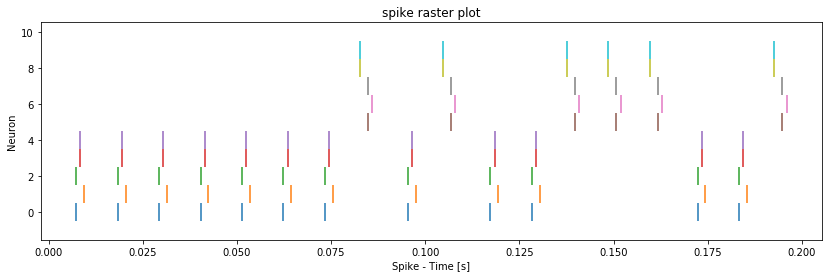

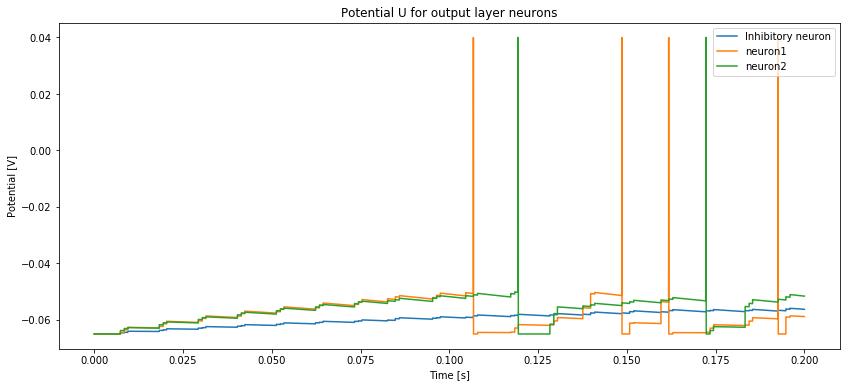

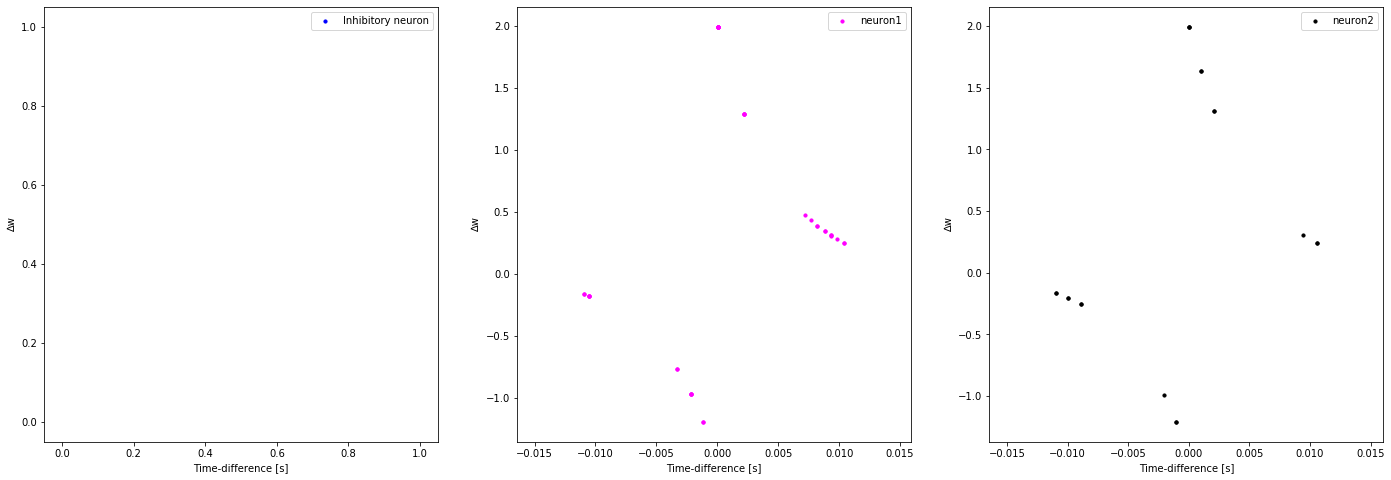

In [182]:
simul_STDP(0.0015, 0.01, 0.001, 1.5, 3, 5, -1.5, 2, 0.005 )

weights:
 [[ 4.92573006  0.58254743 14.34041497]
 [ 0.31335373  0.23042858  0.14631613]
 [ 5.52992782  0.70784153 13.89919509]
 [ 1.10653576  0.52928394 10.7190993 ]
 [ 0.8608688   0.47994991 10.64952743]
 [ 1.15642065  0.65183427  0.18708394]
 [ 1.21004129  0.2961368   2.04052808]
 [ 0.80581094  0.35411418  0.15880739]
 [ 0.80756778  0.3292286   0.283134  ]
 [ 0.04265186  0.67178866  0.10487971]]


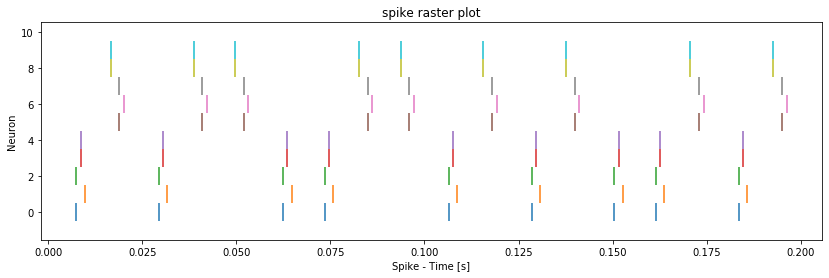

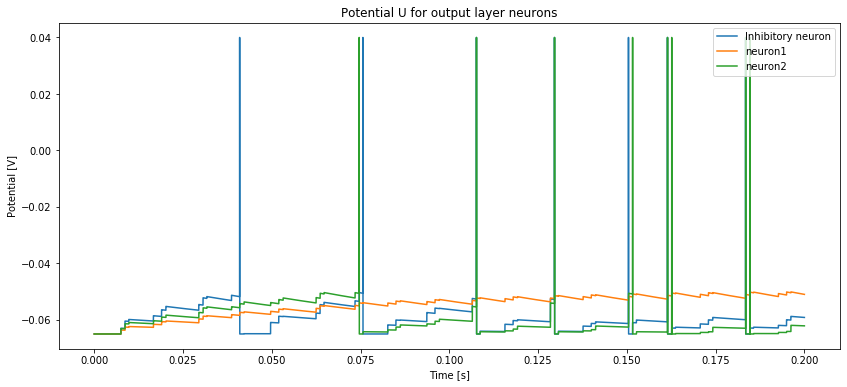

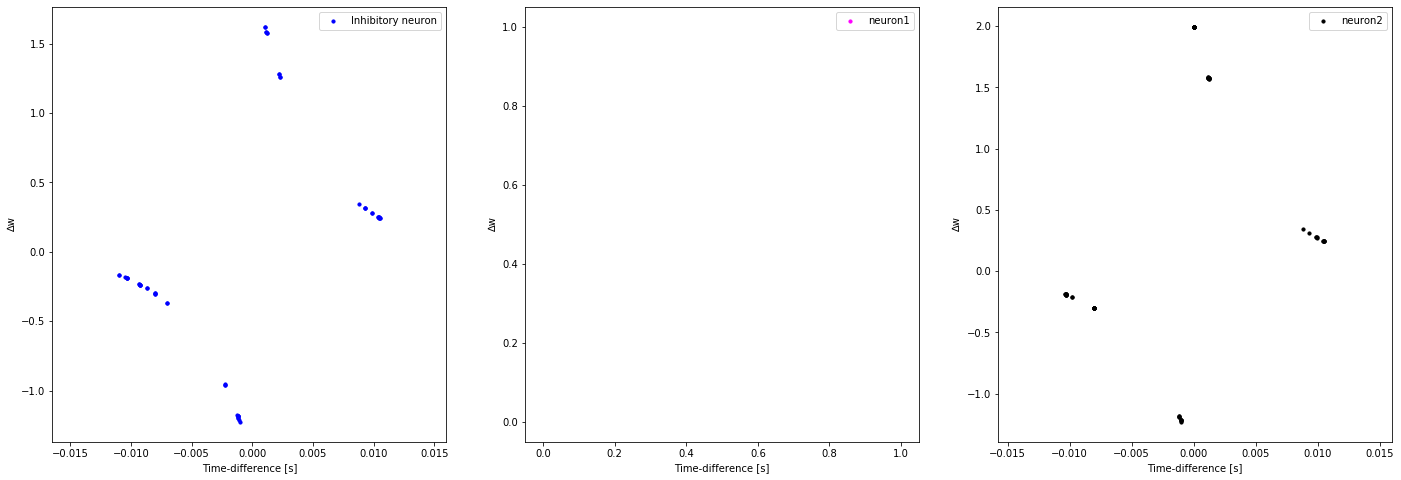

In [200]:
simul_STDP(0.0015, 0.016, 0.001, 3, 7, 5, -1.5, 2, 0.005 )

weights:
 [[ 4.38801683  0.41501081  0.3059817 ]
 [ 0.9349212   0.66038721  1.32453604]
 [ 4.15673171  0.64254112  0.2190152 ]
 [ 1.60299706  0.36048994  0.92559638]
 [ 1.8984538   0.39890983  0.67776259]
 [ 0.0765916   2.05764966 10.23383118]
 [ 0.55862786  2.53352423  1.05455099]
 [ 0.55010058  1.98298002 10.3269276 ]
 [ 0.46723264  1.29286403  5.81516061]
 [ 1.19824564  1.24086657  6.0441788 ]]


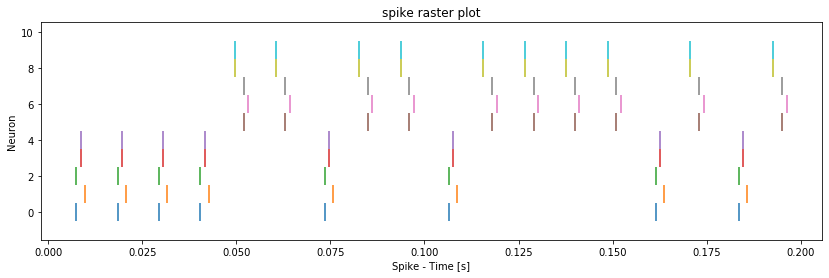

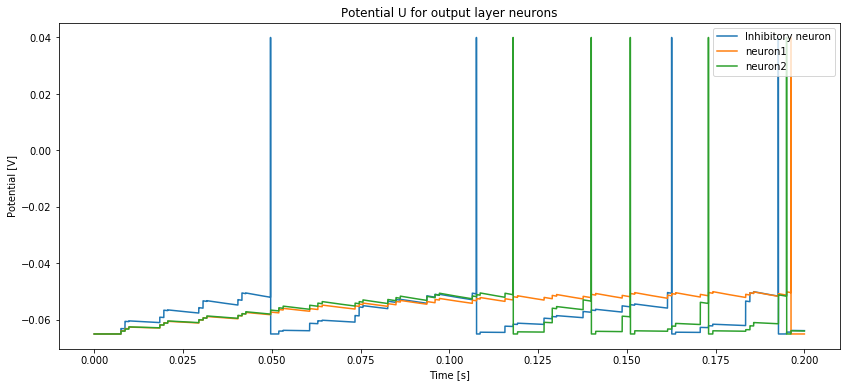

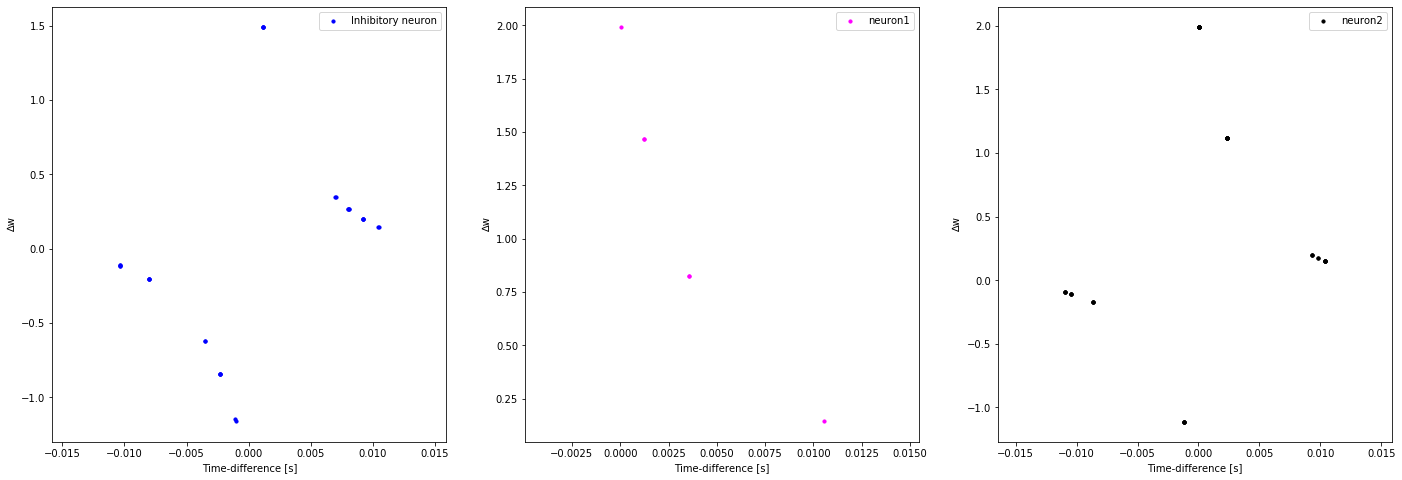

In [203]:
simul_STDP(0.0015, 0.016, 0.001, 3.2, 6.5, 5, -1.5, 2, 0.004 )

weights:
 [[ 4.17881436 16.96301748  0.26194829]
 [ 0.5915522   0.61581078  0.40297403]
 [ 3.71796378 17.12857672  0.16664491]
 [ 2.48964633 13.0043402   0.10744638]
 [ 2.55151701 13.04702426  0.04736068]
 [ 0.6897435   0.47396482  4.02377715]
 [ 0.6345416   0.8190559   5.52682847]
 [ 0.68581959  0.13238576  4.26085424]
 [ 0.60068959  0.54989553  4.00901688]
 [ 0.67081896  0.57101506  4.1116014 ]]


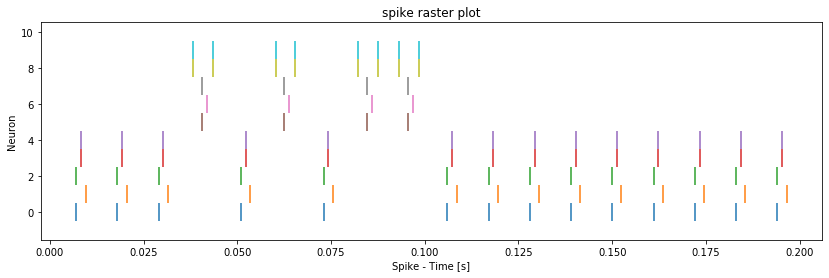

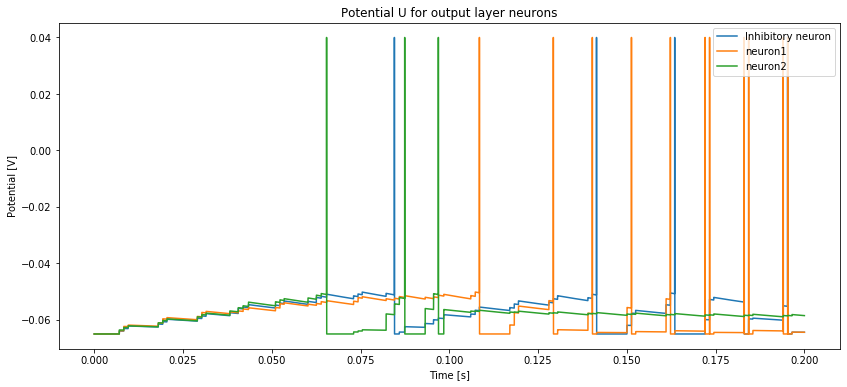

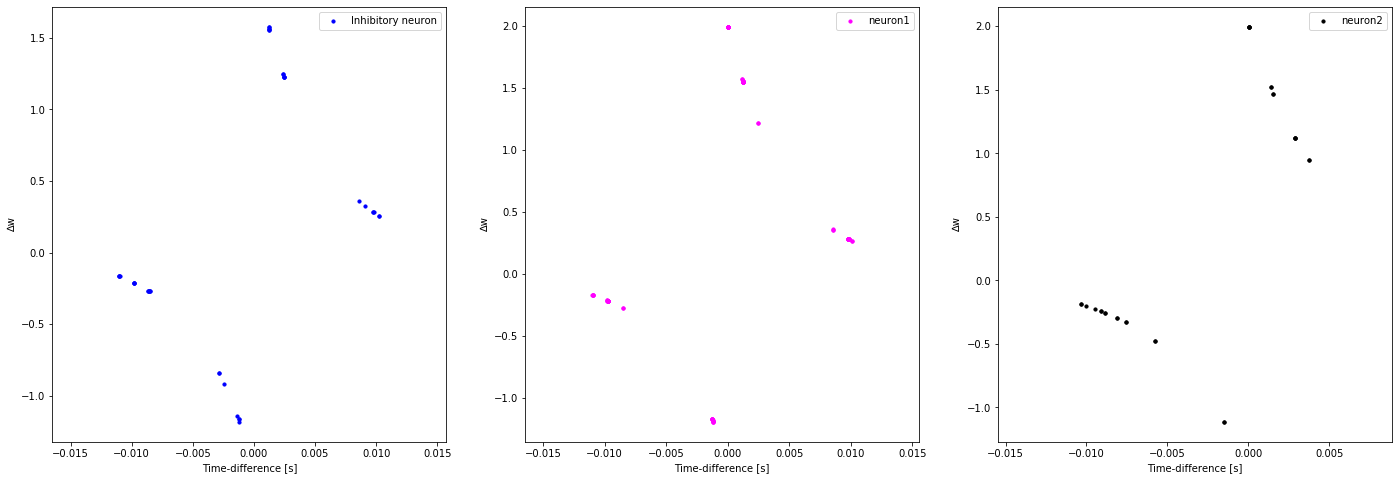

In [213]:
simul_STDP(0.0015, 0.016, 0.001,5, 5, 5, -1.5, 2, 0.005 )

weights:
 [[ 2.64294406  0.26143987  0.92331863]
 [ 1.06406494  0.26480981  3.30658127]
 [ 2.35099103  0.33843388  0.92843974]
 [ 1.06980781  0.24283159  1.9602864 ]
 [ 0.97900581  0.5013922   1.77354692]
 [ 0.13161105  0.33408949 20.12045399]
 [ 0.94372585  0.33930226  9.85331199]
 [ 0.24421413  0.13507559 20.85925918]
 [ 0.41049025  0.23107041 32.10954773]
 [ 0.12575325  0.47107529 32.47991453]]


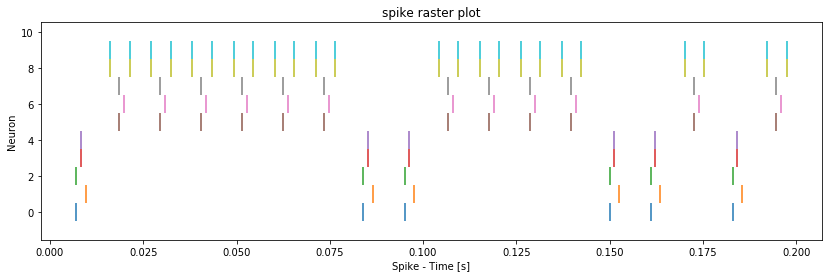

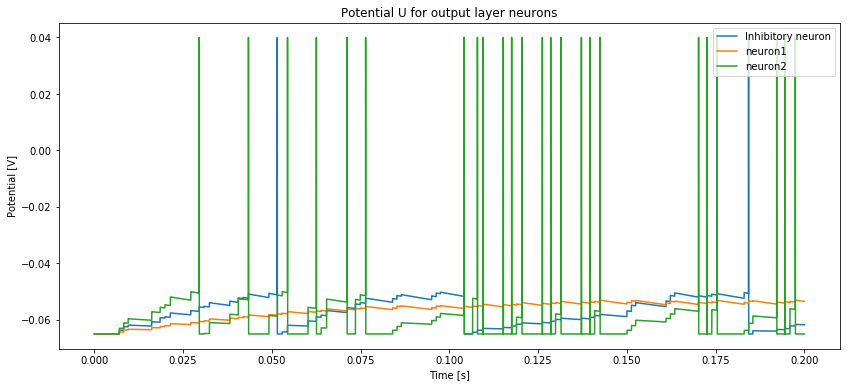

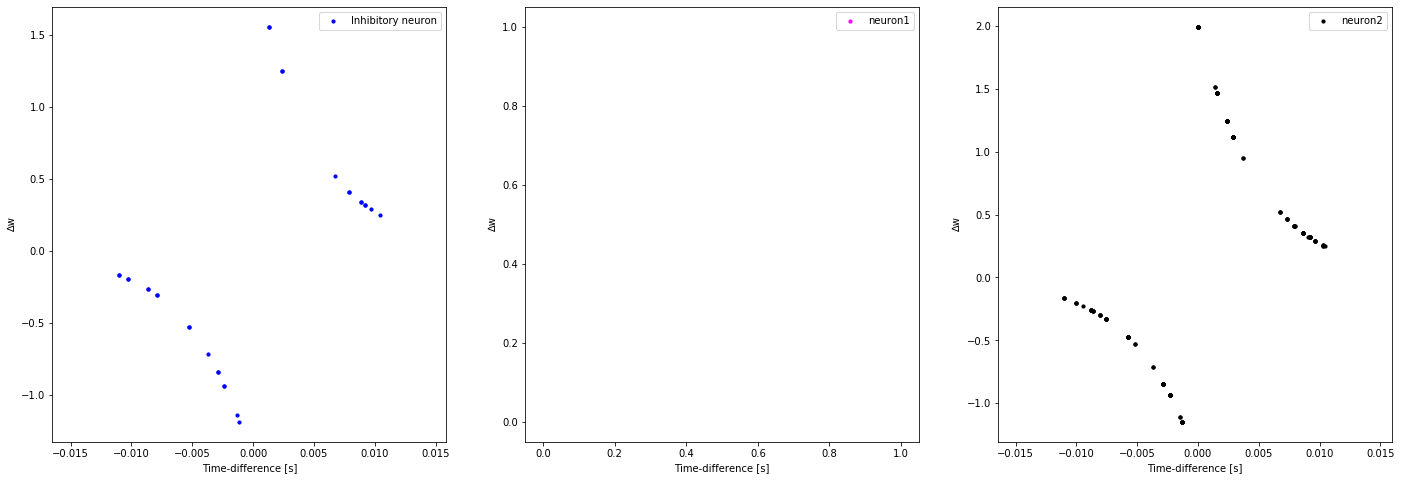

In [217]:
simul_STDP(0.0015, 0.016, 0.001, 5, 9, 3, -1.5, 2, 0.005)

weights:
 [[8.23699077 0.36021752 4.75557296]
 [0.6496488  0.38036329 0.84488978]
 [7.60985844 0.1867955  4.94513983]
 [1.89688532 0.64660707 6.30778989]
 [1.72833793 0.45469805 6.35618869]
 [0.58640605 3.49081332 0.44147381]
 [0.92034867 4.62635504 0.34463714]
 [0.68976134 3.47505069 0.47481586]
 [0.44241112 1.89117222 0.45669133]
 [0.43857068 1.88838556 0.37797056]]


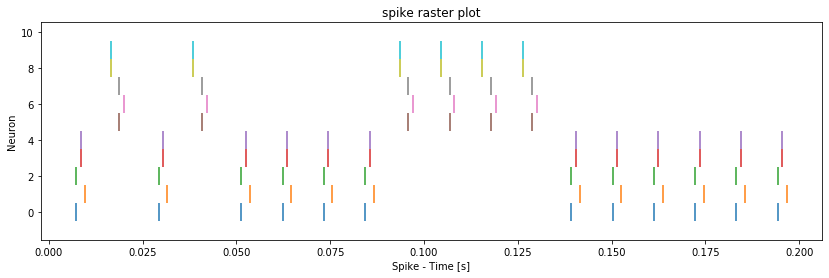

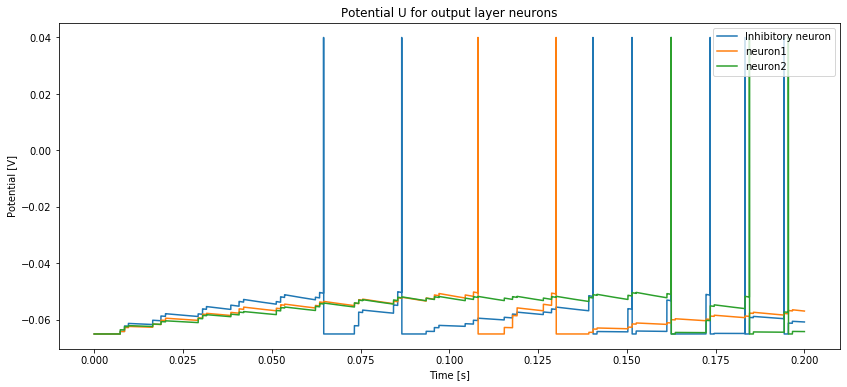

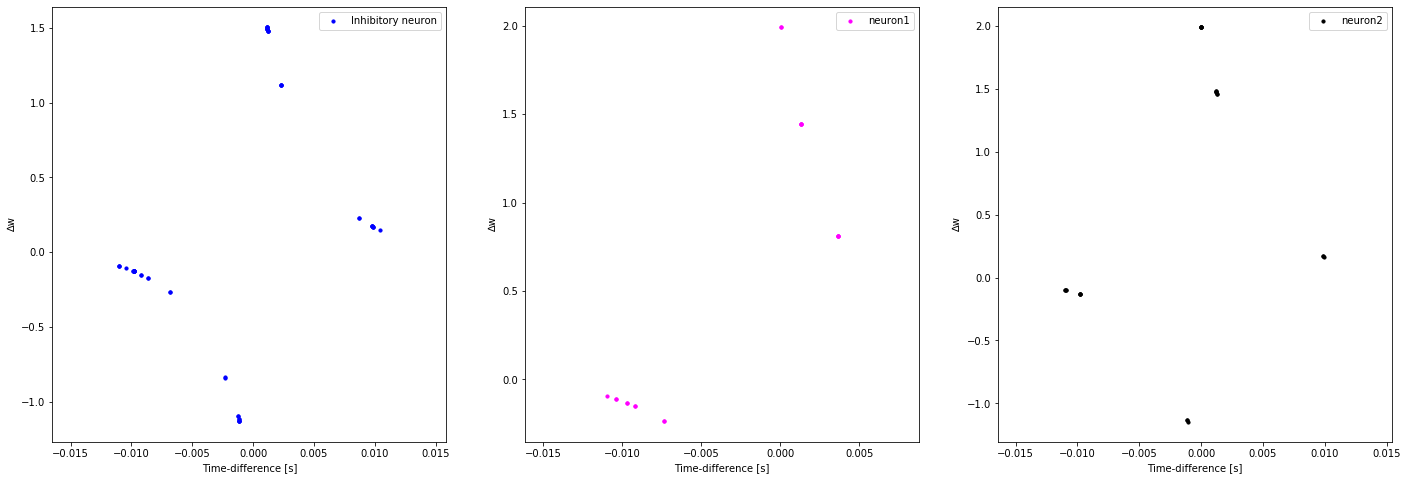

In [221]:
simul_STDP(0.0015, 0.016, 0.001, 4, 6, 6, -1.5, 2, 0.004 )

weights:
 [[2.09027477 5.90076414 0.5218444 ]
 [0.80195448 0.86588446 0.10336829]
 [3.19554371 5.3262957  0.42898529]
 [1.65601857 3.17294855 0.2945733 ]
 [1.47711362 3.36185233 0.23628532]
 [0.9145795  0.69472758 0.38617802]
 [0.32618984 1.00296359 0.58373573]
 [0.13270294 0.61790507 0.29703229]
 [1.82592074 0.18307483 0.50708632]
 [2.24053661 0.20969523 0.33148093]]


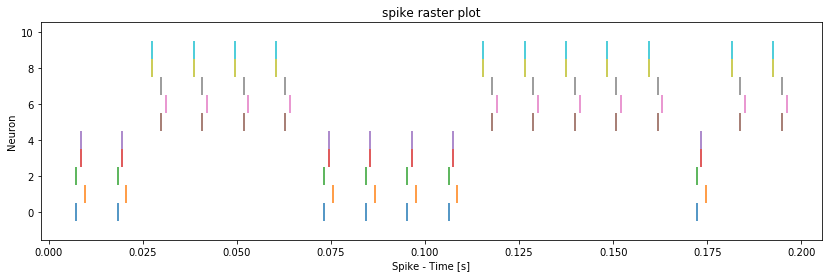

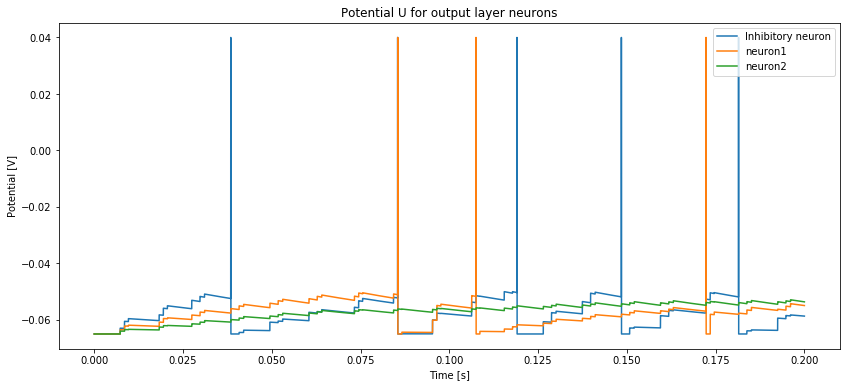

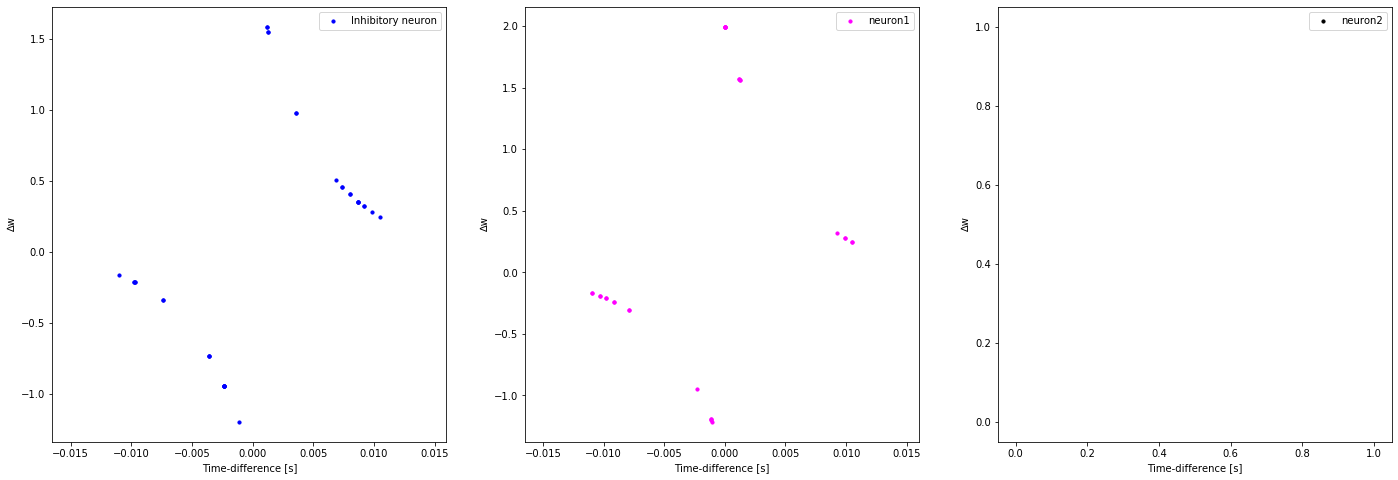

In [222]:
simul_STDP(0.0015, 0.016, 0.001, 3, 5, 7, -1.5, 2, 0.005)

weights:
 [[2.36670525e+00 1.22329113e+01 5.04789292e+00]
 [3.41166250e+00 7.58437781e-01 5.18613092e-01]
 [1.89939691e+00 1.25697278e+01 5.08675647e+00]
 [1.64906217e+00 1.01725125e+00 6.40443331e+00]
 [1.47803619e+00 3.27486373e-01 6.58318133e+00]
 [2.29067501e-04 1.92639795e+00 1.30627129e-02]
 [2.08674621e-01 1.98606259e+00 1.52341685e+00]
 [3.68231188e-01 1.17434632e+00 1.29307348e-01]
 [5.94006536e+00 1.73566303e-01 2.05661109e-02]
 [6.05276655e+00 4.69558130e-02 3.11857937e-02]]


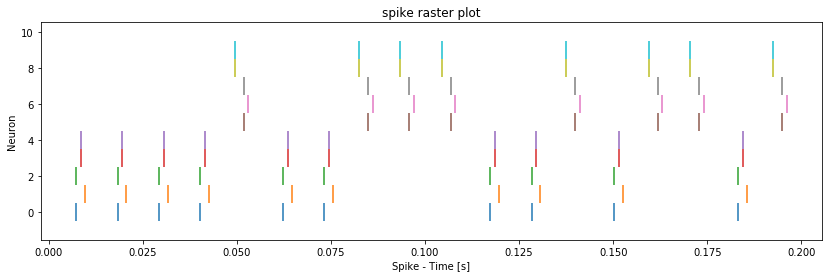

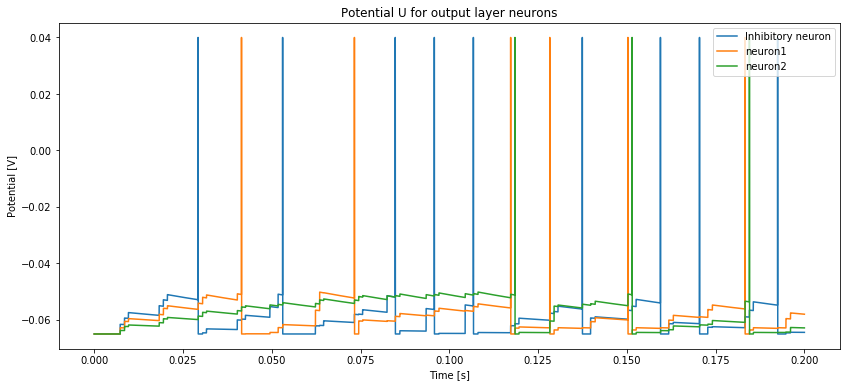

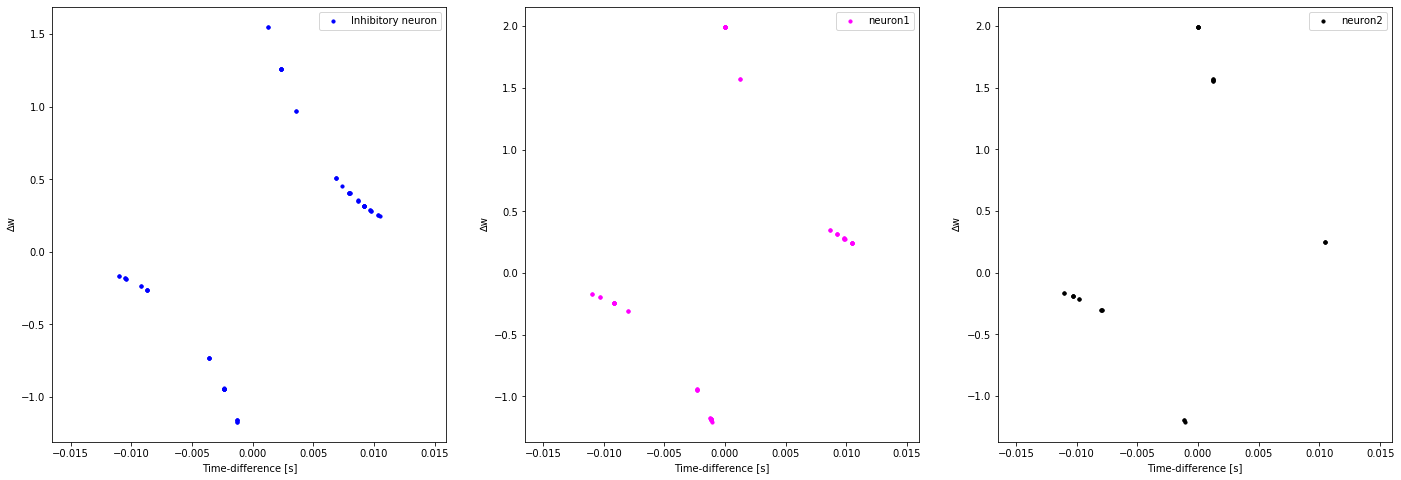

In [224]:
simul_STDP(0.0015, 0.016, 0.001, 2, 3, 5, -1.5, 2, 0.005)

weights:
 [[6.85466853e+00 9.36240121e-03 6.04353945e+00]
 [5.58163982e-01 1.84772515e+00 7.01155657e-01]
 [6.58726822e+00 6.19164339e-03 6.31127950e+00]
 [8.95557858e-01 1.70406977e+00 8.16709481e+00]
 [6.91523752e-02 1.23519698e+00 7.99350961e+00]
 [1.34690107e+00 1.16694136e+01 4.81457579e-02]
 [1.79816199e+00 9.09792981e-01 5.25995431e-01]
 [1.55054076e+00 1.15908593e+01 1.85195323e-01]
 [4.05936666e-01 2.43642880e+00 2.30793684e-01]
 [1.10651536e+00 2.28938515e+00 3.19280122e-01]]


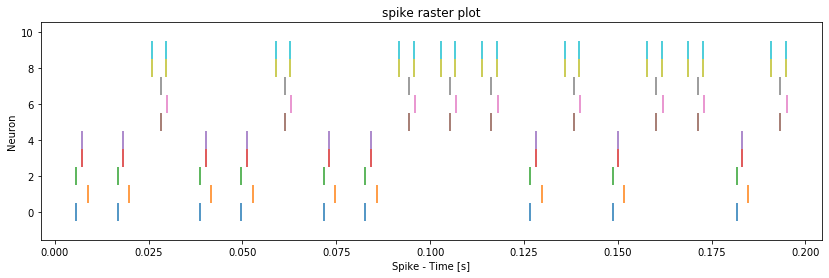

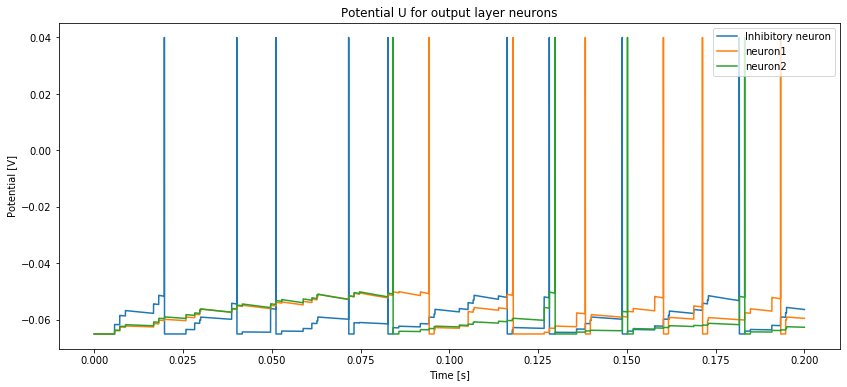

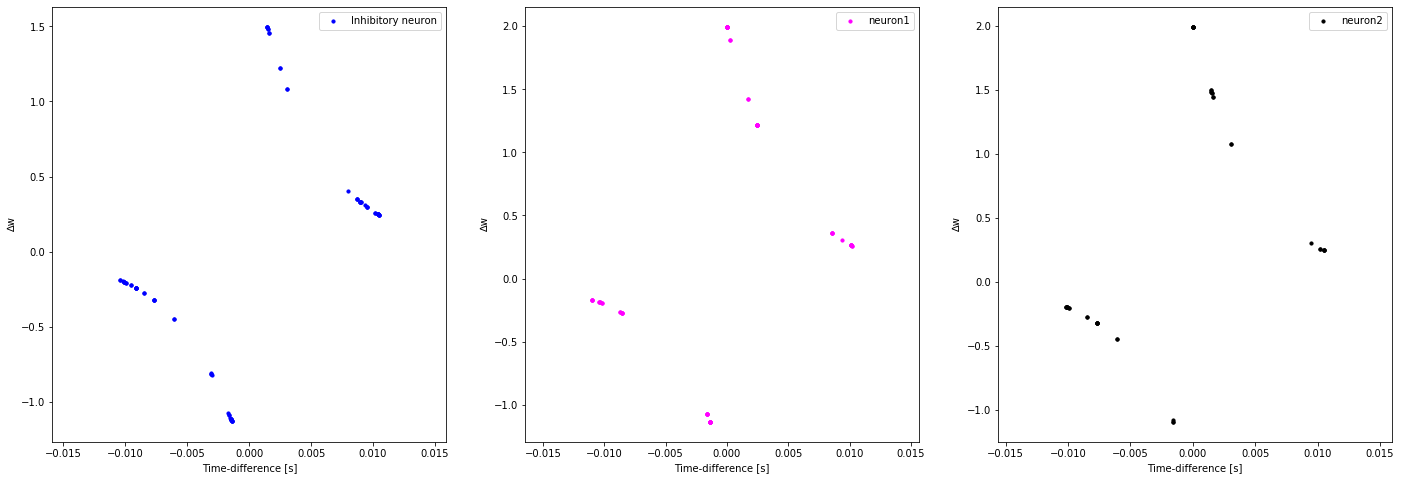

In [205]:
simul_STDP(0.0015, 0.016, 0.001, 2, 5, 5, -1.5, 2, 0.005)

weights:
 [[6.81568328 3.81543879 8.09625736]
 [0.41092324 0.92832611 0.40449369]
 [6.51852291 4.01830448 8.15256926]
 [0.60665792 1.07121776 6.43502344]
 [0.20546299 1.00634719 6.41965529]
 [2.75652456 2.10580152 0.60063555]
 [2.9516437  3.06546752 1.58731096]
 [2.66235226 1.95843052 0.40963563]
 [0.10703782 1.03641012 0.23364362]
 [0.38997293 1.6605174  0.24161087]]


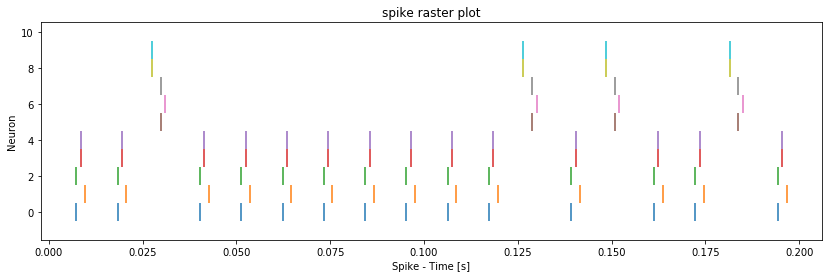

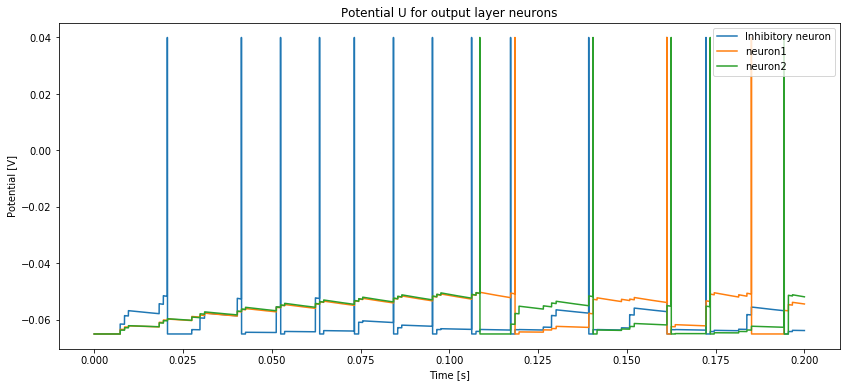

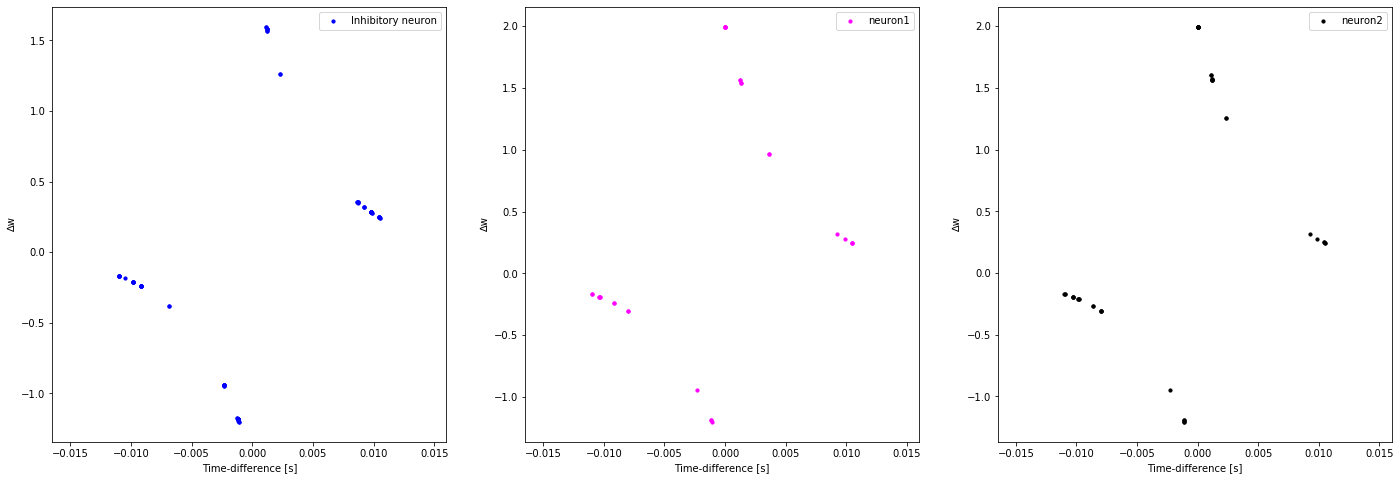

In [231]:
simul_STDP(0.0015, 0.016, 0.001, 2, 5, 5, -1.5, 2, 0.005)

weights:
 [[ 7.69224233  9.88870962 14.58520881]
 [ 0.54088677  1.03296824  0.70427312]
 [ 8.64339452  9.31277517 14.27542721]
 [ 0.11118679  1.9460984  12.12521445]
 [ 0.35817609  2.37580179 12.11814719]
 [ 1.19361867  5.44230986  0.07222045]
 [ 1.4476413   0.85527206  0.64817729]
 [ 1.13638632  4.97206067  0.05683331]
 [ 0.32801528  8.01280425  0.15656353]
 [ 0.11454087  8.12947084  0.21234741]]


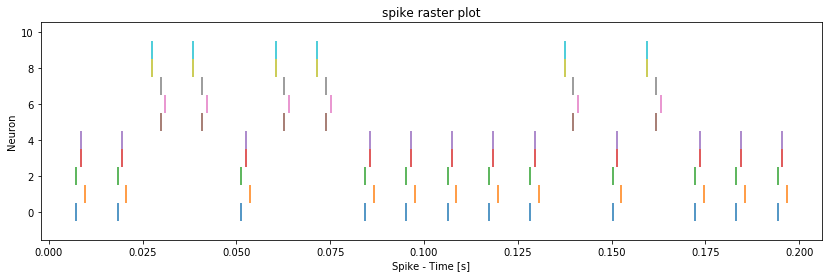

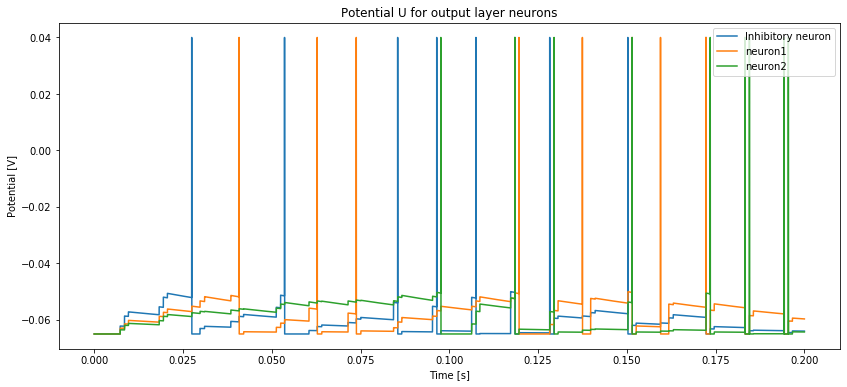

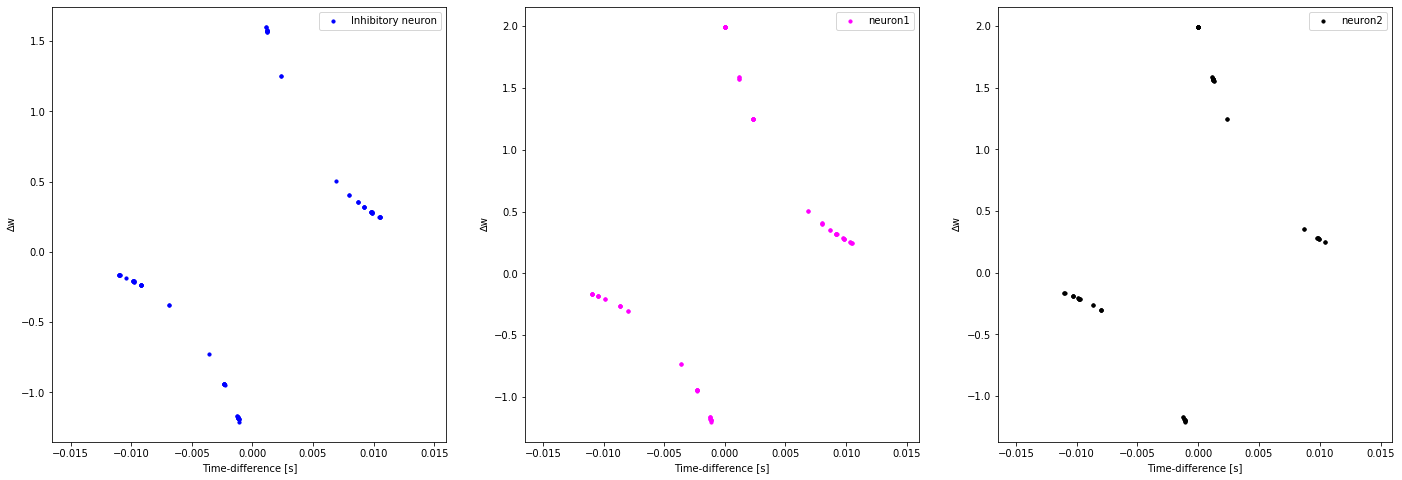

In [235]:
simul_STDP(0.0015, 0.016, 0.001, 2, 3, 5, -1.5, 2, 0.005)

weights:
 [[ 3.94265118 14.44530771  0.52621473]
 [ 0.10841785  0.3037708   0.28309328]
 [ 3.75498386 14.82279066  0.28869423]
 [ 0.97091306 11.80603477  0.26146002]
 [ 1.13432645 11.62748105  0.28349267]
 [ 0.37455903  0.39186849  0.29086068]
 [ 0.42964913  1.5397243   0.49706309]
 [ 0.03420248  0.31638506  0.85037067]
 [ 0.56258003  0.16911373  0.36432235]
 [ 0.51026943  0.0801659   0.10280592]]


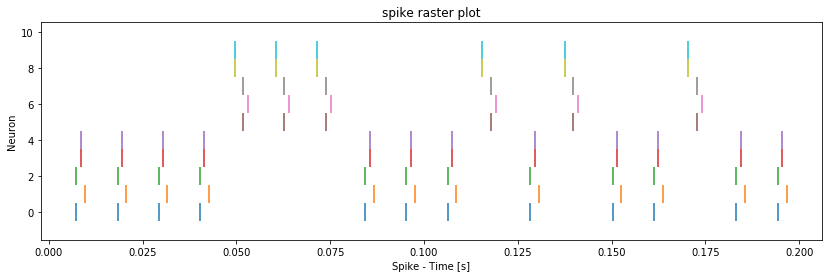

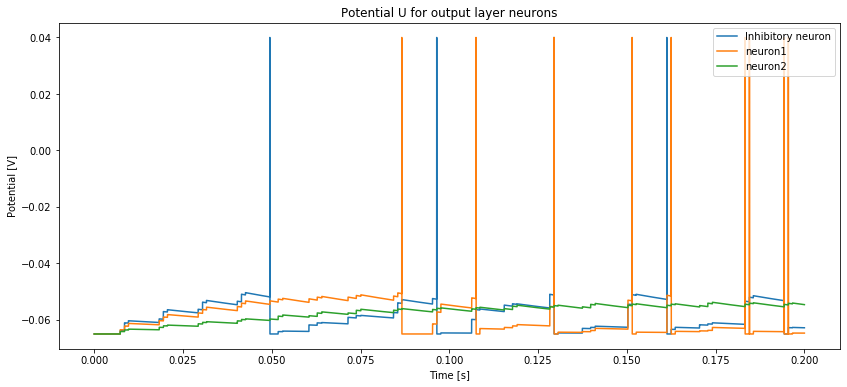

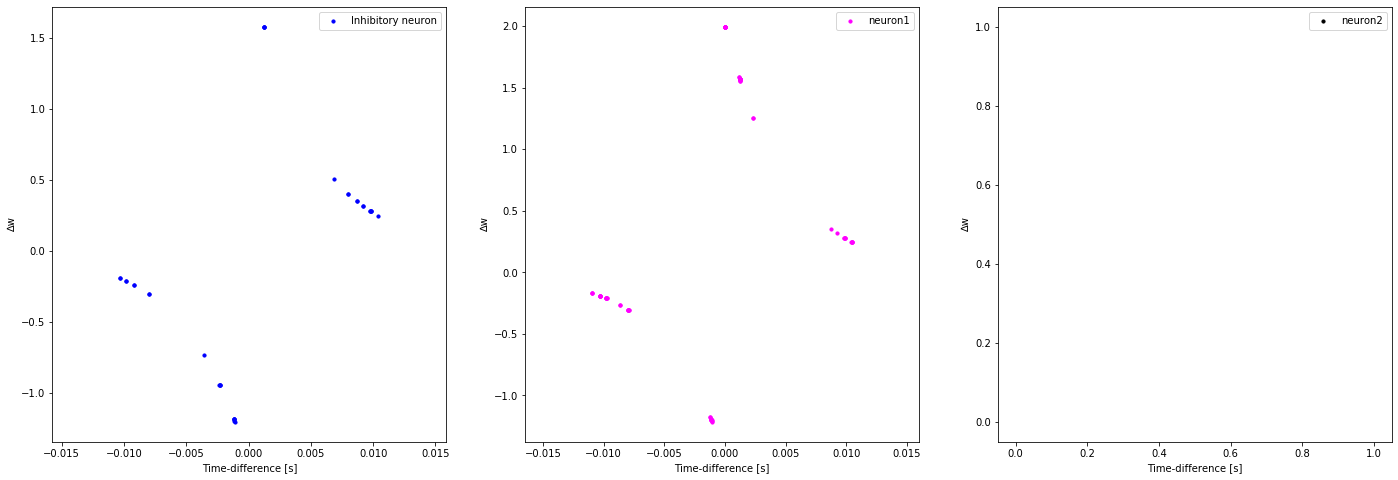

In [238]:
simul_STDP(0.0015, 0.016, 0.001, 3, 5, 7, -1.5, 2, 0.005)

weights:
 [[ 4.73692574  0.02315986  0.37442429]
 [ 0.47648687  1.77711923  0.58768523]
 [ 3.52446388  0.01834205  0.46777451]
 [ 0.12959268  1.49517732  0.61051279]
 [ 0.0461906   1.28036959  0.43967923]
 [ 0.50558754 10.43429957  0.434582  ]
 [ 1.86279148  0.79906109  0.60308727]
 [ 1.03452033 10.05328952  0.54442277]
 [ 0.37429607  6.03727368  0.37665497]
 [ 0.53696471  6.27971716  0.25879918]]


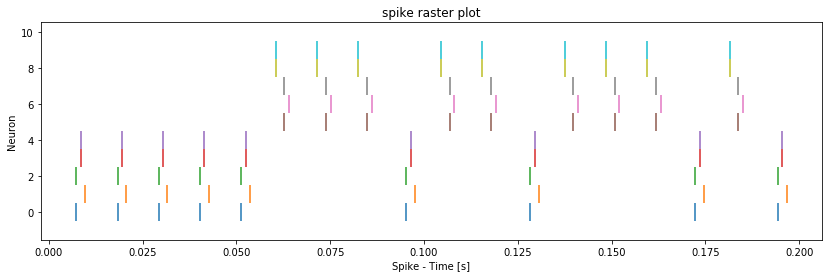

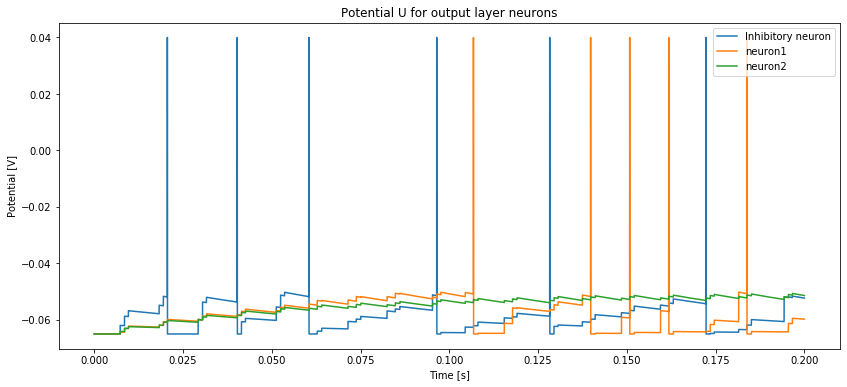

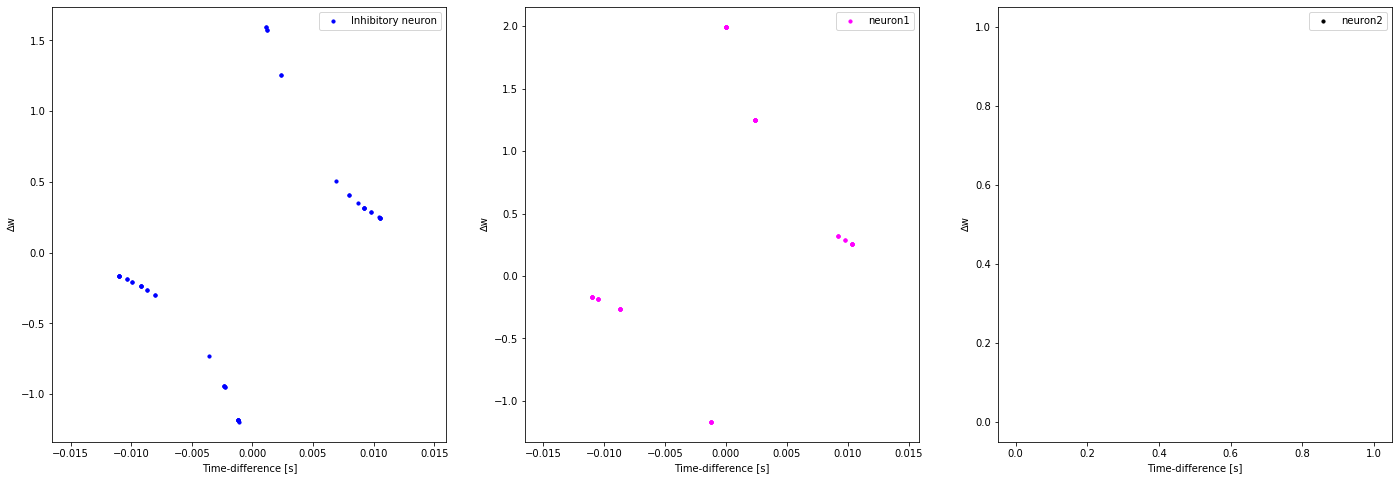

In [239]:
simul_STDP(0.0015, 0.016, 0.001, 2, 5, 7, -1.5, 2, 0.005)

weights:
 [[ 5.87203232  2.92581674  3.37606448]
 [ 0.43215295  2.01753061  1.52820235]
 [ 5.88906667  2.83322887  3.30396306]
 [ 1.19150444  1.77617662  4.6839428 ]
 [ 0.50810469  1.0795648   4.15826359]
 [ 0.55978613 13.32642613  0.12422838]
 [ 1.55002256  1.07686047  0.59545471]
 [ 1.08515473 12.2614253   0.23731065]
 [ 1.06690164 11.37767424  0.08125031]
 [ 0.95660125 11.81873703  0.3231697 ]]


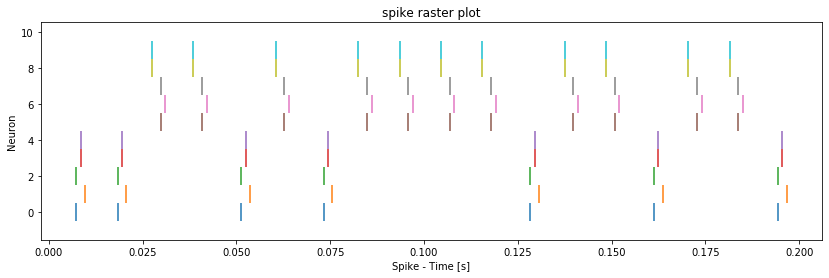

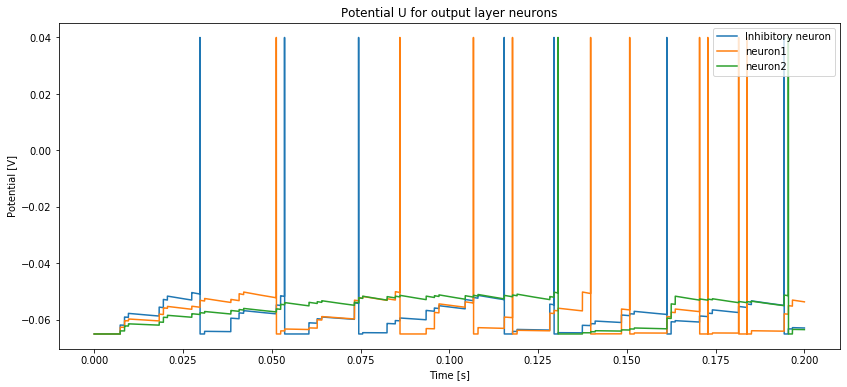

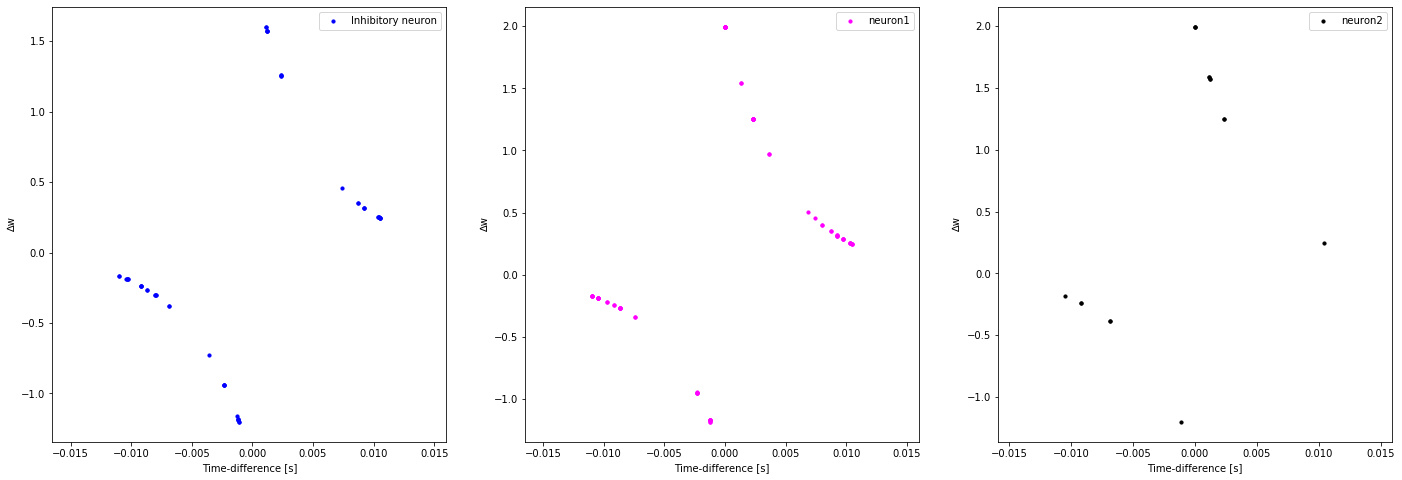

In [243]:
simul_STDP(0.0015, 0.016, 0.001, 2, 3, 5, -1.5, 2, 0.005)

weights:
 [[ 4.0428628  12.65578964  3.67734077]
 [ 0.60796221  0.70177306  1.80634459]
 [ 4.27814283 12.43408051  3.7465193 ]
 [ 0.75360026  1.03646399  1.00980706]
 [ 0.31240427  1.19435387  0.67246431]
 [ 4.81708996  1.52445024  4.61722672]
 [ 1.12327335  1.67390253  1.09730858]
 [ 5.6032917   1.54652     5.03322231]
 [ 3.09893046  0.15858714  3.26092853]
 [ 3.81380878  0.19938957  2.67389309]]


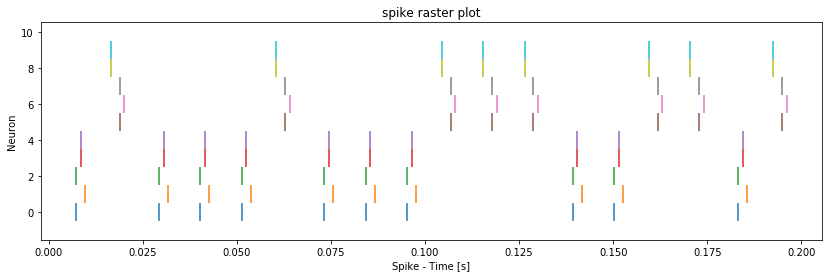

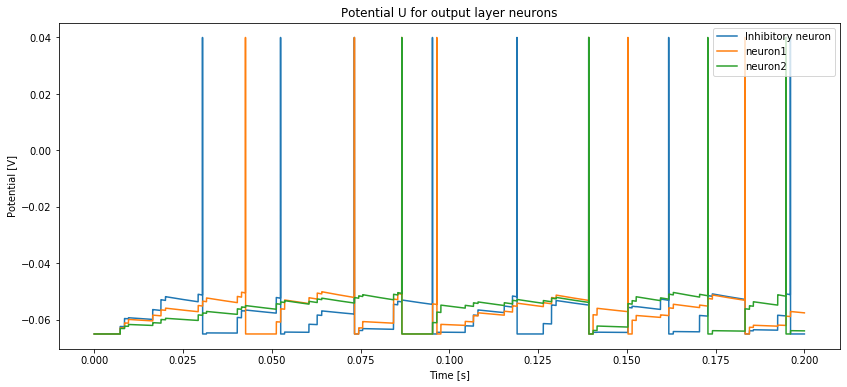

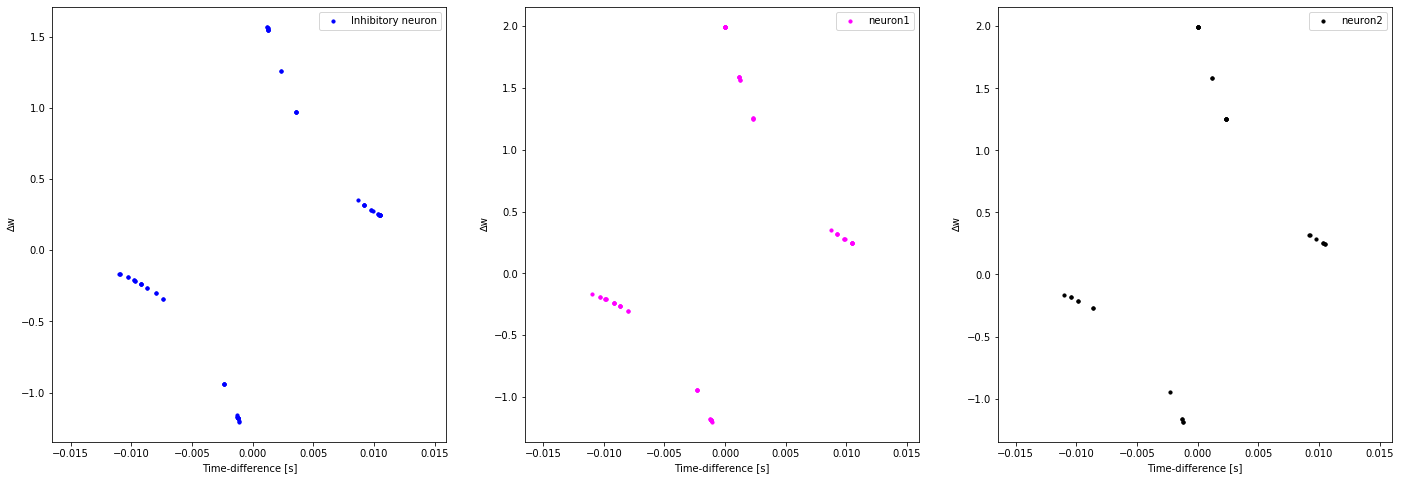

In [5]:
simul_STDP(0.0015, 0.016, 0.001, 2, 3, 5, -1.5, 2, 0.005)

Sharare Zolghadr (610395109)                                                         
Computational Neuroscience